In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import os
#import lmod
# lmod.load('system')
# lmod.load('texlive')
# lmod.
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
#

#data_file_name = 'data/sacct_serc_20200622.out'
#data_file_name = 'data/sacct_serc_20200724.pkl'

In [3]:
# load_pickle=True
# pkl_name = "{}.pkl".format(os.path.splitext(data_file_name)[0])
# #
# if load_pickle:
#     with open(pkl_name, 'rb') as fin:
#         sacct_mazama=pickle.load(fin)
#     #
# else:
#     sacct_mazama = hpc_lib.SACCT_data_handler(data_file_name=data_file_name)
#     #
    
#     with open(pkl_name, 'wb') as fout:
#             #out_pkl = pickle.dump(sacct_demo.jobs_summary, fout)
#             out_pkl = pickle.dump(sacct_mazama, fout)

In [4]:
# n_cpus:
n_cpus = 1
if 'SLURM_JOB_ID' in os.environ.keys():
    # running in SLURM...
    if 'SLURM_JOB_CPUS_PER_NODE' in os.environ.keys():
        n_cpus = max( int(os.environ['SLURM_JOB_CPUS_PER_NODE']), 1)
    else:
        n_cpus = 1
else:
    n_cpus = min(8, mpp.cpu_count())
#
# or specify here:
# n_cpus = 8
#
print('** n_cpus: ', n_cpus)

** n_cpus:  8


In [5]:
#end_dtm = dtm.datetime.now()+dtm.timedelta(days=1)
end_dtm = dtm.datetime(2022,2,2)
sacct_h5_file = f'sacct_data/serc_sacct_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'
#start_date = '2021-04-15'
#end_date   = '2021-05-15'
end_date = end_dtm.date()
start_date = end_date - dtm.timedelta(days=180)
print('*** dates: {} - {}'.format(start_date, end_date))
#
# NOTE: additional options can be passed in the more_options=[] arrary, or just as sacct_{option-name}={val}
#
if os.path.isfile(sacct_h5_file):
    print('*** Creating new SACCT object from HDF5 {}'.format(sacct_h5_file))
    SACCT_obj = hpc_lib.SACCT_data_from_h5(sacct_h5_file, keep_raw_data=False, n_cpu=n_cpus)
    #
    print(f'** {sacct_h5_file}')
    SACCT_obj.write_hdf5(sacct_h5_file)
else:
    print('*** Fetching SACCT data directly')
    SACCT_obj = hpc_lib.SACCT_data_direct(group=None, partition='serc', start_date=str(start_date),
                                          n_cpu=n_cpus,
                                          end_date=str(end_date), keep_raw_data=False)
    #
#
print('** ', SACCT_obj.jobs_summary.dtype.names)

*** dates: 2021-08-06 - 2022-02-02
*** Creating new SACCT object from HDF5 sacct_data/serc_sacct_20220202.h5
** sacct_data/serc_sacct_20220202.h5
*** DEBUG: updating column [index], type=<i8
*** DEBUG: updating column [User], type=('|S8', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [Group], type=('|S8', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [GID], type=('|S6', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [JobName], type=('|S86', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [JobID], type=('|S20', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [JobIDRaw], type=('|S8', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [Partition], type=('|S4', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [State], type=('|S19', {'h5py_encoding': 'ascii'})
*** DEBUG: updating column [Timelimit], type=<f8
*** DEBUG: updating column [NCPUS], type=<i8
*** DEBUG: updating column [NNodes], type=<i8
*** DEBUG: updating column [Submit], type=<f

In [6]:
max_submit, max_start = [mpd.num2date(numpy.nanmax(SACCT_obj.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]
print('*** max_submit: {}, max_start: {}'.format(*[mpd.num2date(numpy.nanmax(SACCT_obj.jobs_summary[cl]))
                                                   for cl in ['Start', 'Submit'] ]))
print('** cols: ', SACCT_obj.jobs_summary.dtype.names)

*** max_submit: 2022-02-01 12:34:18+00:00, max_start: 2022-02-01 12:33:55+00:00
** cols:  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'JobID_parent')


In [7]:
# NOTE: add this to the __init__. would be nice to refactor the code a bit to better handle inheritance.
if not 'chunk_size' in SACCT_obj.__dict__.keys():
    print('*** assigning chunk_size: ', chunk_size)
    SACCT_obj.chunk_size=1000

In [8]:
#
cpu_usage = SACCT_obj.active_jobs_cpu()
#
bin_size=7
cpu_weekly = SACCT_obj.active_jobs_cpu(bin_size=bin_size, t_min=None)

In [9]:
print('** ', len(cpu_usage))
print('** \n', cpu_usage[0:10])

**  5000
** 
 [(18842.8159838 , 1., 72.) (18842.85233403, 1., 72.)
 (18842.88868426, 1., 72.) (18842.9250345 , 1., 72.)
 (18842.96138473, 1., 72.) (18842.99773496, 1., 72.)
 (18843.03408519, 1., 72.) (18843.07043543, 1., 72.)
 (18843.10678566, 1., 72.) (18843.14313589, 1., 72.)]


<ipython-input-10-873d9167c620>:2: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('211')
<ipython-input-10-873d9167c620>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('212', sharex=ax1)
<ipython-input-10-873d9167c620>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)


[Text(18825.0, 0, '2021-7-17'),
 Text(18850.0, 0, '2021-8-11'),
 Text(18875.0, 0, '2021-9-5'),
 Text(18900.0, 0, '2021-9-30'),
 Text(18925.0, 0, '2021-10-25'),
 Text(18950.0, 0, '2021-11-19'),
 Text(18975.0, 0, '2021-12-14'),
 Text(19000.0, 0, '2022-1-8'),
 Text(19025.0, 0, '2022-2-2'),
 Text(19050.0, 0, '2022-2-27')]

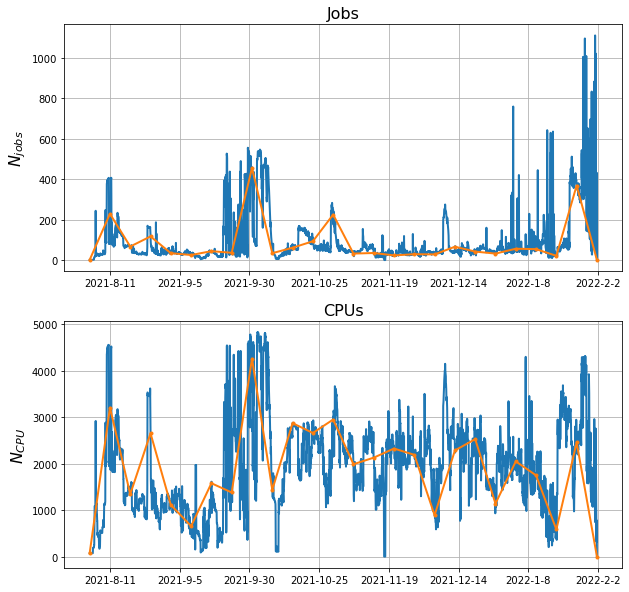

In [10]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_usage['time'], cpu_usage['N_jobs'], ls='-', lw=2., marker='')
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='.')
#
ax2.plot(cpu_usage['time'], cpu_usage['N_cpu'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='.')
#

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
# fix_to_ascii(s)
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(s.get_text()))) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax2.set_xticklabels(lbls)



In [19]:
# def time_bin_aggregates(XY, bin_mod=24, qs=[.25, .5, .74]):
#     XY=numpy.array(XY)
#     if XY.shape[0]==2:
#         X = XY[0,:]
#         Y = XY[1:]
#     else:
#         X = XY[:,0]
#         Y = XY[:,1]
#     #
#     #X_mod = ((X*bin_mod)%bin_mod).astype(int)
#     X_mod = ((X%1.)*bin_mod).astype(int)
#     #
#     stats_output=[]
#     for x in numpy.unique(X_mod):
#         ix = X_mod==x
#         this_Y = Y[ix]
#         stats_output += [numpy.append([x, numpy.mean(this_Y), numpy.std(this_Y)],
#                                       numpy.quantile(this_Y, qs))]
#     #
#     return numpy.core.records.fromarrays(numpy.array(stats_output).T, dtype=[('x', '>f8'), ('mean', '>f8'),
#                                                         ('stdev', '>f8')] + 
#                                          [('q_{}'.format(q), '>f8') for q in qs])
# #

    

<ipython-input-11-70aae9fac9e3>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('121')
<ipython-input-11-70aae9fac9e3>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('122')


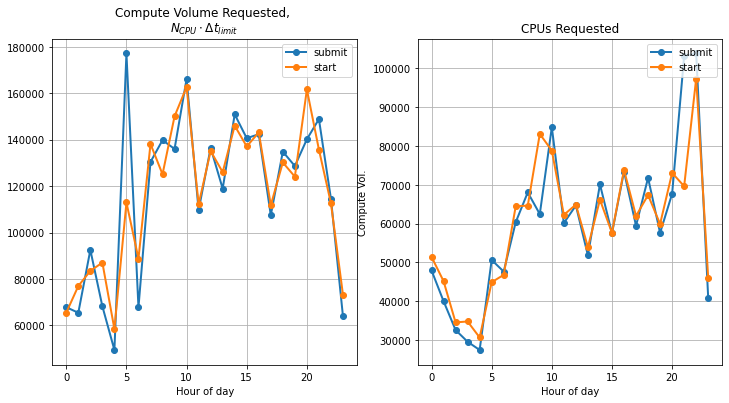

In [11]:
qs = [.5, .75, .95]
#
comp_vol_submit = SACCT_obj.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = SACCT_obj.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot('121')
ax2 = fg.add_subplot('122')
ax1.grid()
ax2.grid()
#

# N = numpy.sum(comp_vol_submit['cpu-time'])
N = 1.
ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/N,
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))
#
# N = numpy.sum(comp_vol_start['cpu-time'])
N = 1 
ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/N,
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/N))
#
#N=numpy.sum(comp_vol_submit['cpus'])
N=1.
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/N, ls='-', marker='o', lw=2., label='submit')

#N=numpy.sum(comp_vol_start['cpus'])
N=1
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/N, ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Compute Vol.')

ax2.set_title('CPUs Requested')
ax2.set_xlabel('Hour of day')
ax2.legend(loc=1, numpoints=1)

Text(0.5, 0.98, 'Instantaneous Usage')

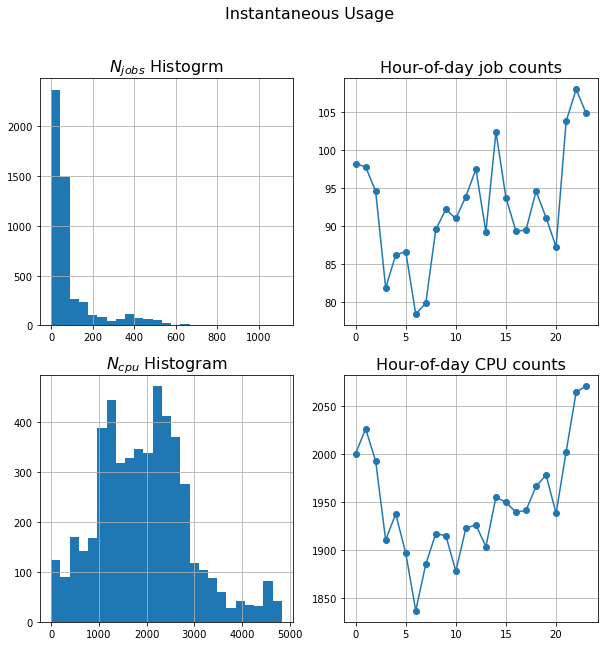

In [12]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
axs = [ax1, ax2, ax3, ax4]
[ax.grid() for ax in axs]
#
cpu_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'], cpu_usage['N_cpu']]).T)
jobs_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'], cpu_usage['N_jobs']]).T)

hh1 = ax1.hist(sorted(cpu_usage['N_jobs'])[0:int(1.0*len(cpu_usage))], bins=25, cumulative=False)
ax2.plot(jobs_hourly['x'], jobs_hourly['mean'], ls='-', marker='o')

hh3 = ax3.hist(cpu_usage['N_cpu'], bins=25)
ax4.plot(cpu_hourly['x'], cpu_hourly['mean'], ls='-', marker='o')

#ax1.set_ylim(-5., 200)
ax1.set_title('$N_{jobs}$ Histogrm', size=16)
ax2.set_title('Hour-of-day job counts', size=16)
ax3.set_title('$N_{cpu}$ Histogram', size=16)
ax4.set_title('Hour-of-day CPU counts', size=16)
#
plt.suptitle('Instantaneous Usage', size=16)

In [22]:
weekly_hours = SACCT_obj.get_cpu_hours(bin_size=7, n_points=5000)

daily_hours = SACCT_obj.get_cpu_hours(bin_size=1, n_points=5000)

<ipython-input-23-182b562b06b0>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(lbls)


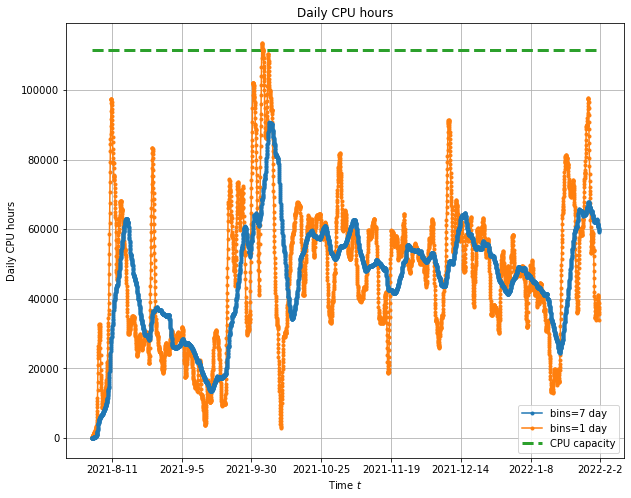

In [23]:
fg = plt.figure(figsize=(10,8))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(weekly_hours['time'], weekly_hours['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
ax1.plot(daily_hours['time'], daily_hours['cpu_hours'], ls='-', marker='.', label='bins=1 day', zorder=5)
#
#ax1.plot( daily_hours['time'][0::(len(daily_hours['time'])-1)], numpy.ones(2)*14*24*24, ls='--', lw=3.)
#ax1.plot( daily_hours['time'][0::(len(daily_hours['time'])-1)], numpy.ones(2)*12*24*24, ls='--', lw=3.)
#
n_cpus_serc = 32*104 + 128*8 + 24*12
n_cpus_serc_gpus = n_cpus_serc + 128*6 + 24*2
ax1.plot( daily_hours['time'][0::(len(daily_hours['time'])-1)], numpy.ones(2)*24*n_cpus_serc, ls='--', lw=3.,
         label='CPU capacity')
#ax1.plot( daily_hours['time'][0::(len(daily_hours['time'])-1)], numpy.ones(2)*24*n_cpus_serc_gpus, ls='--', lw=3.)




#
fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(s.get_text()))) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax1.set_xticklabels(lbls)
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('Daily CPU hours')
ax1.set_title('Daily CPU hours')
#
ax1.legend(loc=0)

In [17]:
print('** dtype:\n', SACCT_obj.jobs_summary.dtype)
#
#user_cols  = ['Timelimit', 'NCPUS', 'NNodes', 'TotalCPU','NTasks']
#user_types = ['>f8', '>i8', '>i8', '>f8', '>i8', '>f8']

user_cols = ['NCPUS', 'NNodes', 'Elapsed', 'Comp_Vol']
user_types = ['>i8', '>i8', '>f8', '>f8']
#
user_aggs = numpy.zeros( shape=[len(numpy.unique(SACCT_obj.jobs_summary['User'])),],
                        dtype={'names':user_cols, 'formats':user_types })
#
ix = {usr:numpy.where(SACCT_obj.jobs_summary['User']==usr)[0] 
      for usr in numpy.unique(SACCT_obj.jobs_summary['User'])}
#

** dtype:
 [('index', '<i8'), ('User', 'S8'), ('Group', 'S8'), ('GID', 'S6'), ('JobName', 'S86'), ('JobID', 'S20'), ('JobIDRaw', 'S8'), ('Partition', 'S4'), ('State', 'S19'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'S9'), ('Suspended', 'S8'), ('ReqTRES', 'S50'), ('AllocTRES', 'S64'), ('JobID_parent', 'S20')]


In [18]:
print('*** ', user_aggs.shape, user_aggs.dtype)
print('*** ', user_cols)
user_names = numpy.unique(SACCT_obj.jobs_summary['User'])
for k,user in enumerate(user_names):
    #print('** ', [numpy.sum(SACCT_obj.jobs_summary[cl][ix[user]]) for cl in user_cols])
    #
    vals = [numpy.sum( numpy.max([numpy.zeros(len(ix[user])), SACCT_obj.jobs_summary[cl][ix[user]]], axis=0) ) 
                      for cl in user_cols[:-1]]
    vals += [numpy.sum(SACCT_obj.jobs_summary['Elapsed'][ix[user]]*24. * SACCT_obj.jobs_summary['NCPUS'][ix[user]])]
    #print('** ix: ', ix[user])
    #vals = [numpy.sum( (SACCT_obj.jobs_summary[cl][ numpy.array(ix[user])] ) )
    #        for cl in user_cols]
    #print('** vals: ', vals)
    
    #user_aggs[user_cols][k] = tuple([numpy.sum(SACCT_obj.jobs_summary[cl][ix[user]]) for cl in user_cols])
    
    user_aggs[user_cols][k] = tuple( vals )
    #user_aggs[user_cols][k] = tuple(vals)



***  (100,) [('NCPUS', '>i8'), ('NNodes', '>i8'), ('Elapsed', '>f8'), ('Comp_Vol', '>f8')]
***  ['NCPUS', 'NNodes', 'Elapsed', 'Comp_Vol']


In [ ]:
# print('** user, {}'.format(user_cols ) )
# for nm,rw in zip(user_names, user_aggs):
#     print('** {}: {}, '.format(nm,rw))

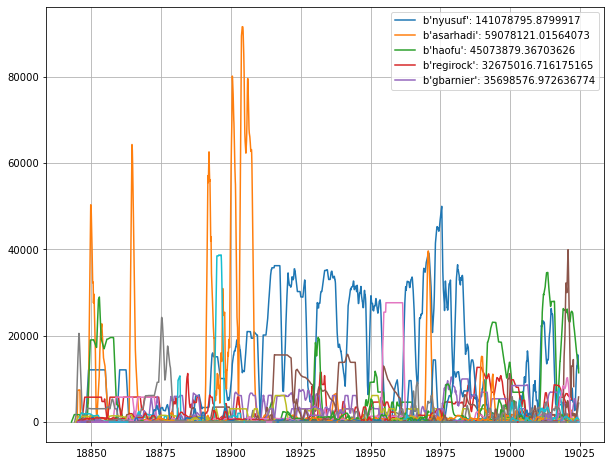

In [20]:
fg = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.grid()
for k,usr in enumerate(user_names[numpy.argsort(user_aggs['Comp_Vol'])[::-1]]):
    cpuh = SACCT_obj.get_cpu_hours(bin_size=1.0, jobs_summary=SACCT_obj.jobs_summary[ix[usr]])
    ax.plot(cpuh['time'], cpuh['cpu_hours'], label=('{}: {}'.format(usr, numpy.sum(cpuh['cpu_hours']) )
                                                    if k<5 else None) )
ax.legend(loc=0)

<ipython-input-21-ba0d35d16ea0>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('121')
<ipython-input-21-ba0d35d16ea0>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('122')


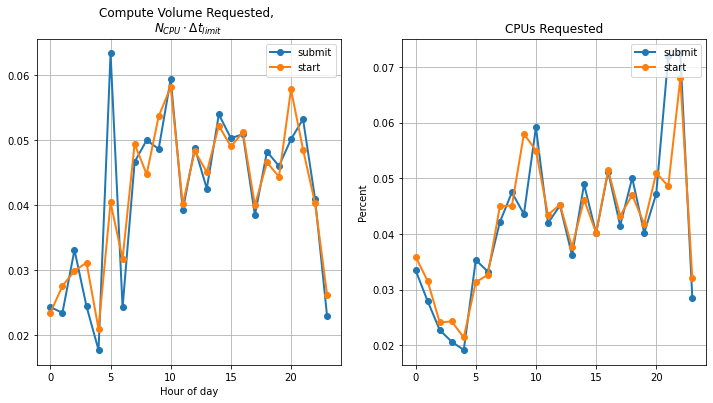

In [21]:
# time of day(-like) compute volume requests.

qs = [.5, .75, .95]
#
comp_vol_submit = SACCT_obj.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = SACCT_obj.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot('121')
ax2 = fg.add_subplot('122')
ax1.grid()
ax2.grid()
#

ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time']),
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))

ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/numpy.sum(comp_vol_start['cpu-time']),
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/numpy.sum(comp_vol_start['cpu-time'])))
#
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/numpy.sum(comp_vol_submit['cpus']), ls='-', marker='o', lw=2., label='submit')
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/numpy.sum(comp_vol_start['cpus']), ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Percent')

ax2.set_title('CPUs Requested')
ax2.legend(loc=1, numpoints=1)

#ax1.set_yscale('log')

***  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'JobID_parent')


Text(0.5, 1.0, '(Cumulative)')

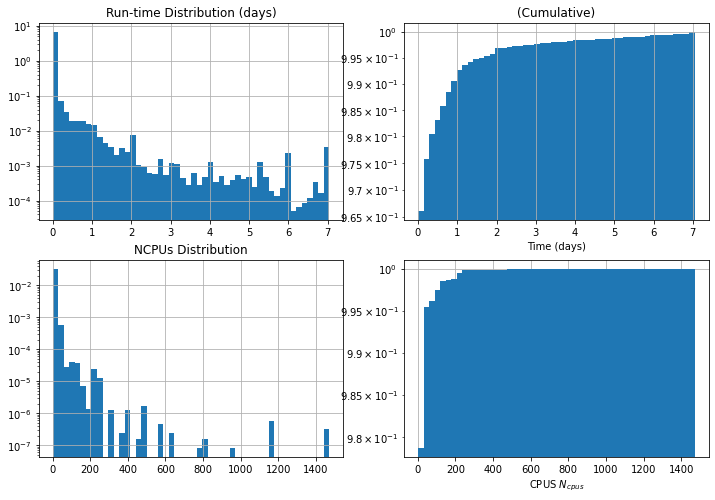

In [22]:
# compute some distributions:
print('*** ', SACCT_obj.jobs_summary.dtype.names)
run_times = SACCT_obj.get_run_times()

#
fg = plt.figure(figsize=(12,8))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
#ax1a.set_yscale('log')
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
#
hh = ax1.hist(run_times, bins=50, cumulative=False, density=True, log=True)
hh1c = ax2.hist(run_times, bins=50, cumulative=True, density=True, log=True, histtype='bar')
#hh1c = ax2.plot(sorted(run_times), numpy.array(numpy.linspace(1./len(run_times), 1.,
#                                                             len(run_times))), lw=3.0, zorder=11)
#
hh2 = ax3.hist(SACCT_obj.jobs_summary['NCPUS'], bins=50, density=True, log=True)
hh22 = ax4.hist(SACCT_obj.jobs_summary['NCPUS'], bins=50, density=True, log=True,
                 cumulative=True, histtype='bar', lw=3, zorder=11)
#hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
#                 cumulative=True, histtype='step', lw=3, zorder=11)
#ax1.plot(run_times, ls='', marker='.')
#print('*** ', run_times[0:20]*24, len(run_times), run_times.shape)
#
ax1.set_title('Run-time Distribution (days)')
ax3.set_title('NCPUs Distribution')
ax2.set_xlabel('Time (days)')
ax4.set_xlabel('CPUS $N_{cpus}$')
#
ax2.set_title("(Cumulative)")
#ax4.set_title("(Cumulative)")

#ax2.set_xlim(-1,800)

In [24]:
print('** ', len(run_times), len(SACCT_obj.jobs_summary['NCPUS']))

**  429805 429810


In [23]:
#ix_rt = numpy.argsort(run_times)
run_times_sorted = run_times.copy()
run_times_sorted.sort()
#
k_2 = numpy.searchsorted(run_times_sorted, 2.0)
k_7 = numpy.searchsorted(run_times_sorted, 7.0)
k_14 = numpy.searchsorted(run_times_sorted, 14.0)

#
# k_2 = numpy.searchsorted(run_times[ix_rt], 2.0)
# #k_7 = numpy.searchsorted(run_times[ix_rt], 7.0)
# k_7 = k_2 + numpy.searchsorted( (run_times[ix_rt])[k_2:], 7.0)
# k_14 = k_7 + numpy.searchsorted( (run_times[ix_rt])[k_7:], 14.0)
#
N=float(len(run_times))
print('*** quantiles for t=2,7,14 days: {}, {}, {}'.format(float(k_2)/N, k_7/N, k_14/N))
#
# percent of jobs that use N<24 cores (aka, can run on a single node). Note that these are especially
#. eligible for GCP.
N_24 = numpy.sum(SACCT_obj.jobs_summary['NCPUS']<25)
print('*** N_24/N={}'.format(N_24/N))


*** quantiles for t=2,7,14 days: 0.9957864613022185, 0.9996370447063203, 1.0
*** N_24/N=0.9785460848524331


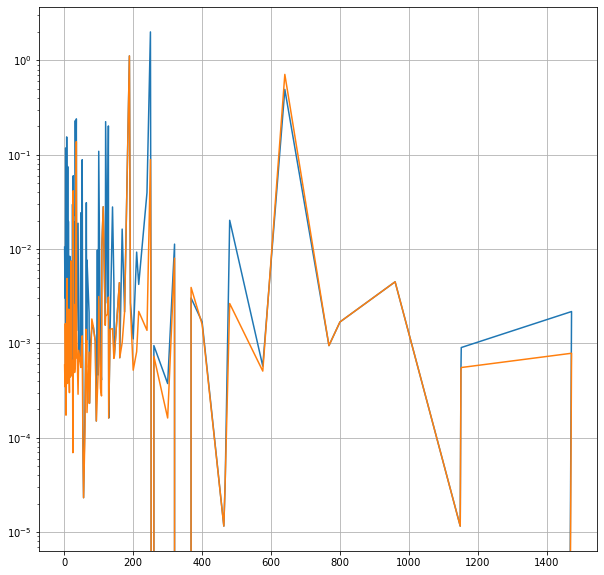

In [24]:
wait_stats = SACCT_obj.get_wait_stats()
#
fg = plt.figure(figsize=(10,10))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(wait_stats['ncpus'], wait_stats['mean'], ls='-', label='mean')
ax1.plot(wait_stats['ncpus'], wait_stats['median'], ls='-', label='median')
#
#ax1.set_ylim(-.1, .5)
ax1.set_yscale('log')
ax1.legend(loc=0)

***  ['2019-10-31', '2020-2-8', '2020-5-18', '2020-8-26', '2020-12-4', '2021-3-14', '2021-6-22', '2021-9-30', '2022-1-8', '2022-4-18']


<ipython-input-25-ff8e6c5bdb1b>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('211')
<ipython-input-25-ff8e6c5bdb1b>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('212', sharex=ax1)
<ipython-input-25-ff8e6c5bdb1b>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)


Text(0.5, 0.98, 'Mazama Activity, $\\Delta t_{binsize}=7$ days')

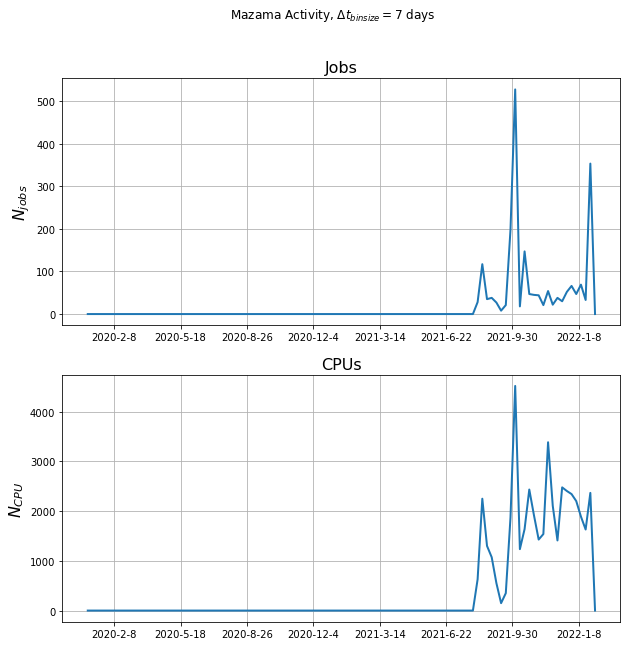

In [25]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
bin_size=7
cpu_weekly = SACCT_obj.active_jobs_cpu(bin_size=bin_size, t_min=t0)
#
fg = plt.figure(figsize=(10,10))
plt.suptitle('Weekly Usage')
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='')

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)
#
plt.suptitle('Mazama Activity, $\Delta t_{{binsize}}={}$ days'.format(bin_size))


***  ['1969-12-31', '1969-12-31', '1969-12-31', '1970-1-1', '1970-1-1', '1970-1-1', '1970-1-1']


<ipython-input-26-794c851249f7>:30: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('211')
<ipython-input-26-794c851249f7>:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('212', sharex=ax1)
<ipython-input-26-794c851249f7>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)


[Text(-0.06, 0, '1969-12-31'),
 Text(-0.039999999999999994, 0, '1969-12-31'),
 Text(-0.019999999999999997, 0, '1969-12-31'),
 Text(0.0, 0, '1970-1-1'),
 Text(0.020000000000000004, 0, '1970-1-1'),
 Text(0.04000000000000001, 0, '1970-1-1'),
 Text(0.06, 0, '1970-1-1')]

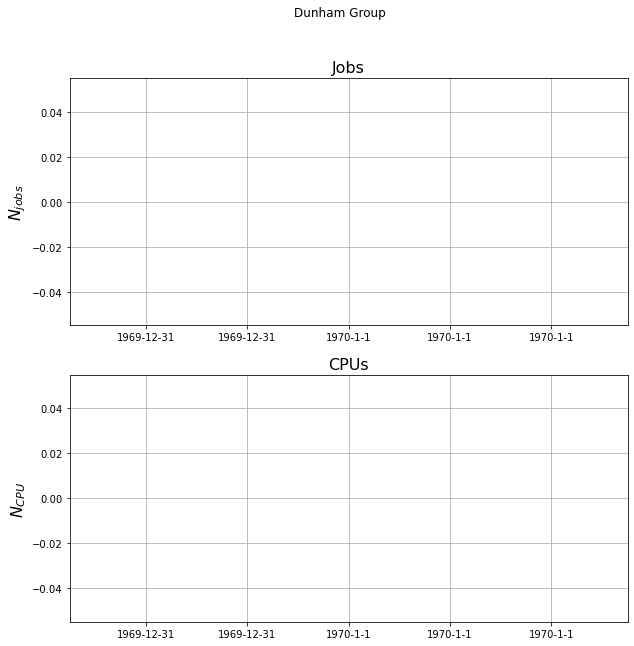

In [26]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
# and get a list of users to construct an index:
# $ finger dunham
# Login: edunham         Name: Eric Dunham
# Directory: /home/edunham             Shell: /bin/bash
# Never logged in.
# No mail.
# No Plan.
# [rcwhite@cees-mgmt0 ~]$ id edunham
# uid=60367(edunham) gid=100(users) groups=100(users),203(tgp),70137(fs-erd)
# [rcwhite@cees-mgmt0 ~]$ getent group | grep tgp
# tgp:*:203:ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,
# gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,schu3,
# lbruhat,kallison,labraha2,kcoppess,edunham
#
users = 'ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,\
gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,\
schu3,lbruhat,kallison,labraha2,kcoppess,edunham'.split(',')
users = [s for s in users if not s in ('myoder96', 'dennis')]
#print('** users: ', users)
#
ix = numpy.array([s in users for s in SACCT_obj.jobs_summary['User'] ])
#print('** ', (sacct_mazama.jobs_summary[ix])[0:20] )
#
cpu_weekly = SACCT_obj.active_jobs_cpu(bin_size=7., t_min=t0, ix=ix)
#
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='')
#
plt.suptitle('Dunham Group')
ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text().replace(chr(8722), '-'))) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)

In [27]:
# if True:
#     with open(data_file_name, 'r') as fin:
#         header_rw = fin.readline()
#         print('*** ', header_rw)

#     headers = header_rw.split('|')
#     k_group = headers.index('Group')
#     k_gid = headers.index('GID')
#     #
    
#     with open(data_file_name, 'r') as fin:
#         for k,rw in enumerate(fin):
#             #if 'dunham' in rw: print('** ', rw)
#             #if 'dunham' in rw:
#             #    rws = rw.split('|')
#             #    print('** ', rws[k_group], rws[k_gid])
#             if 'Partition_Limit' in rw:
#                 print('** ', rw)
#                 k+=1
#                 if k>10: break



In [28]:
print('** ',SACCT_obj.jobs_summary.dtype.names)
print('** ', mpd.num2date(SACCT_obj.jobs_summary['Submit'][-1]))

**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'JobID_parent')
**  2022-02-01 12:33:55+00:00


In [29]:
dta = SACCT_obj.jobs_summary.copy()
dta.sort(order='Submit')

## Drafts of some reports
- We have a couple reports already made. Let's start with those.
- Even for those reports, we'll want to modify the inputs, for example to specify all Earth users/groups, not juust look at the `serc` partition.


In [ ]:
### Report(s)
#
# first, we need to make groups.
# groups who can access serc:
# (base) [myoder96@sh01-ln01 login ~]$ scontrol show partition serc | grep Allow
#   AllowGroups=sh_s-ees,sh_sysadm AllowAccounts=ALL AllowQos=normal,high_p,system
#
# so all permissions are consolidated to the sh_s-ees group
# to get users in a group:
# USERS=`getent passwd | awk -F: -v g=$(id -g $PI_SUNET) '$4==g {print $1}'`
#. but this does not seem to work for the sh_s-ees group
# we can use id to get secondary groups (we'll need to pares...), for example,
# $ (base) [myoder96@sh01-ln01 login ~/Codes/cees_scripts]$ id myoder96
# uid=362778(myoder96) gid=32264(ruthm) groups=99001(sh_users),98013(sh_sw-stata),98008(sh_sw-schrodinger),97002(sh_s-ees),97005(sh_s-hns),1007582(oak_p-cees-backup),1008811(oak_s-ees),32264(ruthm)
# this should do it:
# getent group sh_s-ees
# then maybe just parse in Python...

In [ ]:
# PI_groups = hpc_lib.get_PI_groups_from_groups(groups='sh_s-ees')
# #
# for ky,vl in PI_groups.items():
#     print('** {}, {}'.format(ky,vl))
#     #
# #
# SACCT = hpc_lib.SACCT_data_direct(partition='serc', start_date='2021-01-01', end_date='2021-06-03',
#                                   keep_raw_data=False)
# #
# rpt = hpc_lib.SACCT_groups_analyzer_report(Short_title='SERC HPC Analytics', 
#                 Full_title='HPC Analytics Breakdown for Stanford Earth, Sherlock SERC',
#                 out_path='output/SERC_analytics_20210602', tex_filename='SERC_HPC_analytics.tex',
#                                            groups=PI_groups, SACCT_obj=SACCT)


### CEES Sherlock report(s)
- Let's just get into this... What we need:
- Standard(ish) report of SERC (and other) partition(s) usage
- Mostly same standard report for each active PI group

#### Standard report:
- jobs,cpus
- cpu-hours
- Time-of-Day, Day-of-week usage
- 

#### Basic workflow:
- Get full SACCT data for `serc` partition
- Run report on partition usage
- Get active groups (group name + users?)
- Fetch new SACCT_obj for each group
- Run report for each group.

In [ ]:
#SACCT_obj.write_hdf5('sacct_data/serc_2021_12_01_2022_01_31.h5')

keys:  dict_keys(['All'])
*** DEBUG: group: All


/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:1791: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:1794: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:1838: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [All] Slide_1 added??:: 3


/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:1216: UserWarning: FixedFormatter should only be used together with FixedLocator
  tmp_x = ax.set_xticklabels(['', *[str(int((x%24)/daily_Period) ) for x in ax.get_xticks()[1:]]])


*** Slide_2 added??::  4
** adding slide: slide_2
** adding slide: slide_3


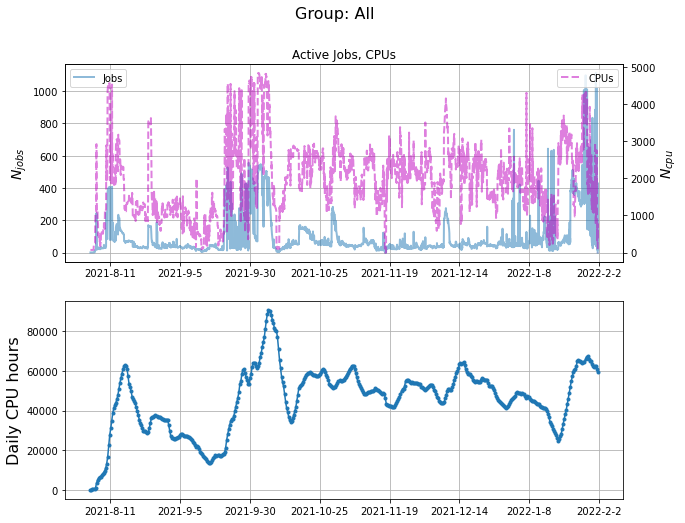

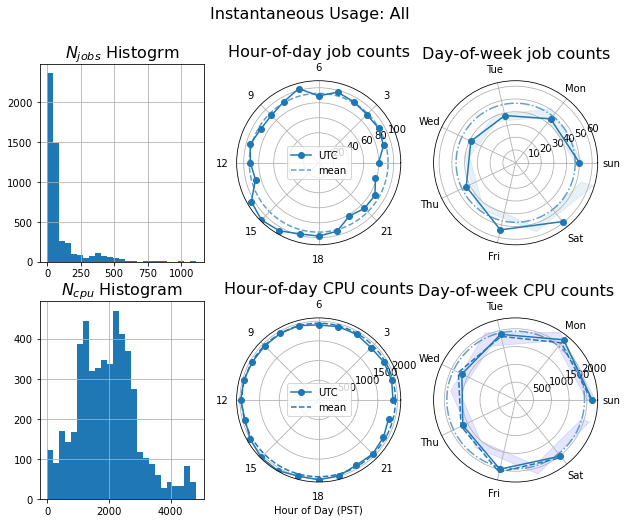

In [30]:
# SACCT_obj = hpc_lib.SACCT_data_direct(partition='serc', start_date='2021-12-01', end_date='2022-01-31',
#                                   keep_raw_data=False)
# SACCT_obj.write_hdf5('sacct_data/serc_2021_12_01_2022_01_31.h5')

serc_report = hpc_lib.SACCT_groups_analyzer_report(Short_title='SERC Analytics', Full_title='SERC HPC analytics',
                                                  SACCT_obj=SACCT_obj,
                                                  out_path='output/SERC_analytics_20220121',
                                                   tex_filename='SERC_HPC_analytics.tex'
                                                  )



/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:2054: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:1222: UserWarning: FixedFormatter should only be used together with FixedLocator
  tmp_x = ax.set_xticklabels(['', *[str(int((x%24)/daily_Period) ) for x in ax.get_xticks()[1:]]])
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:1222: UserWarning: FixedFormatter should only be used together with FixedLocator
  tmp_x = ax.set_xticklabels(['', *[str(int((x%24)/daily_Period) ) for x in ax.get_xticks()[1:]]])


** adding slide: slide_2
** adding slide: slide_3
** adding slide: slide_4


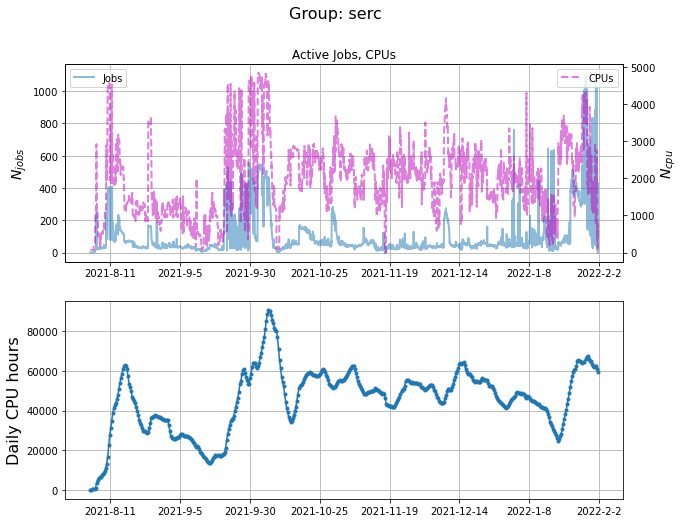

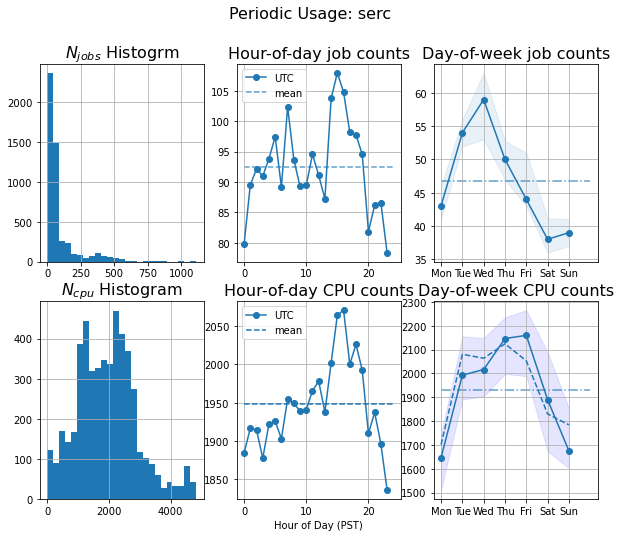

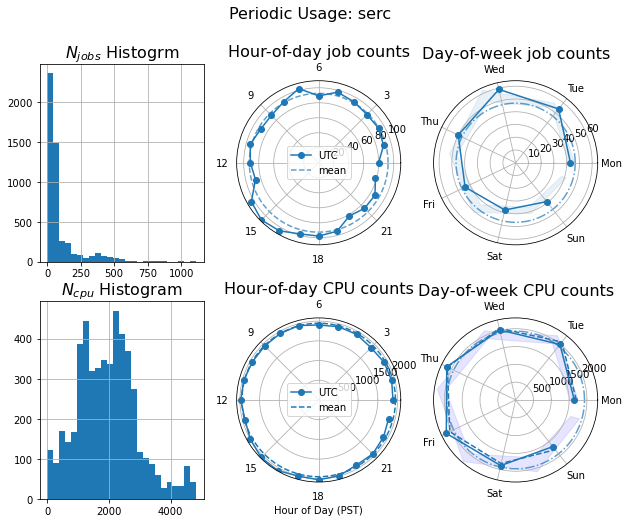

In [13]:
# How to make reports with hpc_lib.SACCT_groups_analyzer_report_handler()
#
serc_report_h = hpc_lib.SACCT_groups_analyzer_report_handler(Short_title='SERC Analytics', Full_title='SERC HPC analytics',
                                                  SACCT_obj=SACCT_obj,
                                                  out_path='output/SERC_analytics_20220121_h',
                                                   tex_filename='SERC_HPC_analytics.tex'
                                                  )
z = serc_report_h.standard_reports_slides(group_name='serc')

#z = serc_report_h.standard_reports_slides(ix=(SACCT_obj.jobs_summary['Group']==b'biondo'), group_name='Biondo')

zz = serc_report_h.HPC_tex_obj.render()
#ix_g_ruthm = numpy.where([SACCT_obj.jobs_summary['User'] ])
#ix_g_ruthm = (SACCT_obj.jobs_summary['Group']=='ruthm')

In [ ]:
SACCT_obj.

In [39]:
hourlies.dtype

dtype([('time', '>f8'), ('t_start', '>f8'), ('cpu_hours', '>f8'), ('N_jobs', '>f8')])

In [60]:

#hourlies = SACCT_obj.get_cpu_hours(bin_size=1./24., d_t=1/24., IX=None, verbose=0)
# NOTE: because we have 1/24 d_t and bin_size, this should be equivalent to active_cpus, but it is not
#. actually computed quite the same way.
hourlies = hpc_lib.get_cpu_hours(bin_size=1./24., d_t=1/24., verbose=0, jobs_summary=SACCT_obj.jobs_summary)

In [61]:
hourlies_cpu_job = hpc_lib.active_jobs_cpu(bin_size=1./24., jobs_summary=SACCT_obj.jobs_summary)

*** DEBUG: 4368, 0.041666666666666664


In [136]:
# I don't know why these are not the same length... something to do with how cpu-hours are computed.
print('lens: ', len(hourlies), len(hourlies_cpu_job))

lens:  4363 4368


In [50]:
# NOTE: num2date(0) is a thursday, so datetime.weekday() == (t+3)%7 or (t-4)%7, so t%7 = {2,3} are sat, sun.
ix_wknd   = numpy.logical_and( (hourlies['time'])%7 >= 2., (hourlies['time'])%7 <= 3. )
ix_afters = numpy.logical_or(hourlies['time']%1.<.3 , hourlies['time']%1>.8)
ix_dollies = numpy.logical_and(numpy.invert(ix_wknd), numpy.invert(ix_afters))

In [140]:
# compute running averages over a full week for the components:
# dollies (9 to 5)
# after hours (weekdays, not 9 to 5)
# weekends.
ave_bins = 7*24
#
X = hourlies['cpu_hours'][:]
#X[ix_wknd]=0.
#X[ix_afters]=0.
X[numpy.invert(ix_dollies)] = 0.
hourlies_cake_9to5 = numpy.cumsum(numpy.insert(X,0,0))[ave_bins:] - numpy.cumsum(numpy.insert(X,0,0))[:-ave_bins]
#
X = hourlies['cpu_hours'][:]
X[numpy.invert(ix_wknd)] = 0.
hourlies_cake_wknd = numpy.cumsum(numpy.insert(X,0,0))[ave_bins:] - numpy.cumsum(numpy.insert(X,0,0))[:-ave_bins]
#
X = hourlies['cpu_hours'][:]
X[numpy.invert(ix_wknd)] = 0.
X[numpy.invert(ix_dollies)] = 0.
hourlies_cake_afters = numpy.cumsum(numpy.insert(X,0,0))[ave_bins:] - numpy.cumsum(numpy.insert(X,0,0))[:-ave_bins]

In [71]:
ix_w   = numpy.logical_and( (hourlies_cpu_job['time'])%7 >= 2., (hourlies_cpu_job['time'])%7 <= 3. )
ix_a   = numpy.logical_or(hourlies_cpu_job['time']%1.<.3 , hourlies_cpu_job['time']%1>.8)
ix_d   = numpy.logical_and(numpy.invert(ix_w), numpy.invert(ix_a))

In [132]:
q_steps = numpy.array([.5, .75, .9])
print('** ', numpy.sum(hourlies_cpu_job['N_cpu']), numpy.sum(hourlies_cpu_job['N_cpu'][ix_d]),
      numpy.sum(hourlies_cpu_job['N_cpu'][ix_a]), numpy.sum(hourlies_cpu_job['N_cpu'][ix_w]))
#
dtype = [('time', '>i8')] + [(f'q{k+1}', '>f8') for k,x in enumerate(q_steps)] 
periodic_hourly_925_cpus = numpy.zeros((24,), dtype=dtype)
periodic_hourly_925_cpus['time'] = numpy.arange(24)
print('** ', periodic_hourly_925_cpus)
print('** ', periodic_hourly_925_cpus['time'])
#
for k in periodic_hourly_925_cpus['time']:
    qs = numpy.nanquantile(hourlies_cpu_job['N_cpu'][numpy.logical_and(numpy.invert(ix_w),
                                    (24*(hourlies_cpu_job['time']%1)).astype(int)==k)], q_steps)
    #print(f'** qs[{k}]: {qs}')
    #
    # what is this syntax????
    #periodic_hourly_925_cpus[('q1', 'q2', 'q3')] = qs[:]
    #if numpy.isnan(qs):
    #    continue
    for j,q in enumerate(qs):
        periodic_hourly_925_cpus[f'q{j+1}'][k]=q
print('** **\n', periodic_hourly_925_cpus)

periodic_daily_925_cpus = numpy.zeros((7,), dtype=dtype)
periodic_daily_cpus = numpy.zeros((7,), dtype=dtype)
periodic_daily_925_cpus['time'] = numpy.arange(7)
periodic_daily_cpus['time'] = numpy.arange(7)
#
for k in periodic_daily_cpus['time']:
    qs_925 = numpy.nanquantile(hourlies_cpu_job['N_cpu'][numpy.logical_and(numpy.invert(ix_d),
                                    (((hourlies_cpu_job['time']+3)%7)).astype(int)==k)], q_steps)
    qs     = numpy.nanquantile(hourlies_cpu_job['N_cpu'][numpy.logical_and(numpy.invert(ix_a),
                                    (((hourlies_cpu_job['time']+3)%7)).astype(int)==k)], q_steps)
    #
    for j,q in enumerate(qs):
        periodic_daily_cpus[f'q{j+1}'][k]=q
    for j,q in enumerate(qs_925):
        periodic_daily_925_cpus[f'q{j+1}'][k]=q

**  8516126.0 3638298.0 4310367.0 1152318.0
**  [( 0, 0., 0., 0.) ( 1, 0., 0., 0.) ( 2, 0., 0., 0.) ( 3, 0., 0., 0.)
 ( 4, 0., 0., 0.) ( 5, 0., 0., 0.) ( 6, 0., 0., 0.) ( 7, 0., 0., 0.)
 ( 8, 0., 0., 0.) ( 9, 0., 0., 0.) (10, 0., 0., 0.) (11, 0., 0., 0.)
 (12, 0., 0., 0.) (13, 0., 0., 0.) (14, 0., 0., 0.) (15, 0., 0., 0.)
 (16, 0., 0., 0.) (17, 0., 0., 0.) (18, 0., 0., 0.) (19, 0., 0., 0.)
 (20, 0., 0., 0.) (21, 0., 0., 0.) (22, 0., 0., 0.) (23, 0., 0., 0.)]
**  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
** qs[0]: [2008.   2670.75 3478.5 ]
** qs[1]: [1982.  2653.  3370.6]
** qs[2]: [1899. 2566. 3192.]
** qs[3]: [1937.   2538.25 3116.  ]
** qs[4]: [1880.  2471.5 3049.5]
** qs[5]: [1923.  2525.  3046.2]
** qs[6]: [1903.5 2464.5 3010.5]
** qs[7]: [1925. 2464. 2863.]
** qs[8]: [1899.5 2450.5 3246.5]
** qs[9]: [1871.   2421.75 3258.  ]
** qs[10]: [1907.  2453.  3183.2]
** qs[11]: [1887.5  2503.25 3296.5 ]
** qs[12]: [1881.5  2499.75 3205.5 ]
** qs[13]: [1875. 

** xx:  1000.0


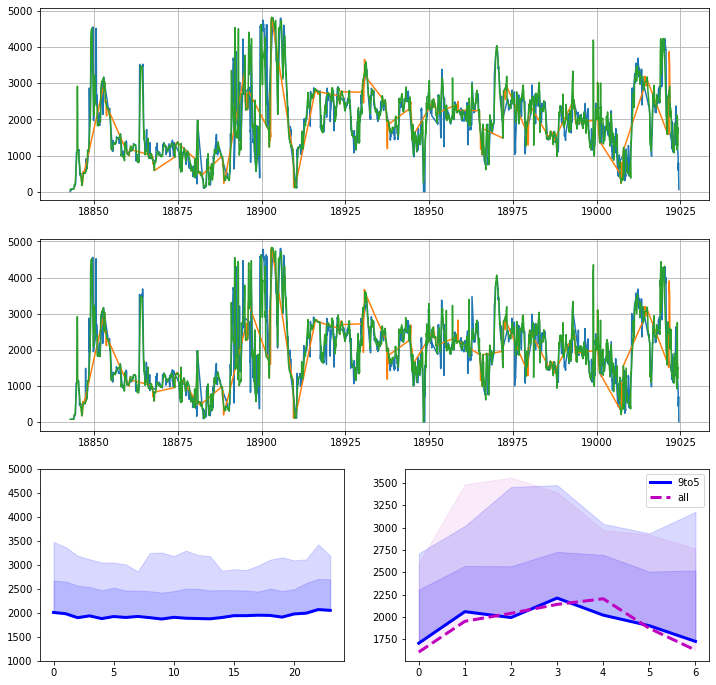

In [134]:
#print('** ', ix_dollies[0:100])
fg = plt.figure(figsize=(12,12))
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,2,5)
ax4 = plt.subplot(3,2,6)
#
ax1.grid()
ax2.grid()
#
T = hourlies['time']
# ix=numpy.logical_and( T%1.>.3 , T%1<.8, (T-4)%7)
# ax.plot(hourlies['time'], hourlies['cpu_hours'])
# ax.plot(hourlies['time'][ix], hourlies['cpu_hours'][ix], ls='', marker='.')

ax1.plot(hourlies_cpu_job['time'][ix_d], hourlies_cpu_job['N_cpu'][ix_d])
ax1.plot(hourlies_cpu_job['time'][ix_w], hourlies_cpu_job['N_cpu'][ix_w])
ax1.plot(hourlies_cpu_job['time'][ix_a], hourlies_cpu_job['N_cpu'][ix_a])
#
ax2.plot(T[ix_dollies], hourlies['cpu_hours'][ix_dollies], ls='-', marker='')
ax2.plot(T[ix_wknd], hourlies['cpu_hours'][ix_wknd], ls='-', marker='')
ax2.plot(T[ix_afters], hourlies['cpu_hours'][ix_afters], ls='-', marker='')
#
ax3.plot(periodic_hourly_925_cpus['time'], periodic_hourly_925_cpus['q1'], lw=3, color='b')
ax3.fill_between(periodic_hourly_925_cpus['time'], periodic_hourly_925_cpus['q1'],
                 periodic_hourly_925_cpus['q2'], color='b', alpha=.15 )
ax3.fill_between(periodic_hourly_925_cpus['time'], periodic_hourly_925_cpus['q1'],
                 periodic_hourly_925_cpus['q3'], color='b', alpha=.15 )

xx = numpy.min(numpy.append([1000], periodic_hourly_925_cpus['q1']))
print('** xx: ', xx)
ax3.set_ylim(xx, 5000)
#
X = periodic_daily_925_cpus
ax4.plot(X['time'], X['q1'], lw=3, color='b', label='9to5')
ax4.fill_between(X['time'], X['q1'], X['q2'], color='b', alpha=.15 )
ax4.fill_between(X['time'], X['q1'], X['q3'], color='b', alpha=.15 )
X = periodic_daily_cpus
ax4.plot(X['time'], X['q1'], lw=3, color='m', ls='--', label='all')
#ax4.plot(X['time'], X['q3'], lw=3, color='m', ls='--')
ax4.fill_between(X['time'], X['q1'], X['q3'], color='m', alpha=.08)
#ax4.fill_between(X['time'], X['q1'], X['q2'], color='b', alpha=.15 )
#ax4.fill_between(X['time'], X['q1'], X['q3'], color='b', alpha=.15 )
ax4.legend(loc=0)

#xx = numpy.min(numpy.append([1000], periodic_hourly_925_cpus['q1']))
#print('** xx: ', xx)
#ax3.set_ylim(xx, 5000)

In [49]:
print('*** ', ix_wknd[0:50])
print('*** ', numpy.sum(ix_wknd))

***  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
***  0


In [101]:
for t in hourlies['time'][0:250]:
    d = mpd.num2date(t)
    print('** time: {}: hour: {}, weekday: {}/{}/{}::{}'.format(t, d.hour, d.weekday(), int(t%7), 
                                                                int(t+3)%7, int(t-4)%7 ))

** time: 18842.791666666664: hour: 19, weekday: 1/5/1::1
** time: 18842.833333333332: hour: 20, weekday: 1/5/1::1
** time: 18842.875: hour: 21, weekday: 1/5/1::1
** time: 18842.916666666668: hour: 22, weekday: 1/5/1::1
** time: 18842.958333333336: hour: 23, weekday: 1/5/1::1
** time: 18843.000000000004: hour: 0, weekday: 2/6/2::2
** time: 18843.04166666667: hour: 1, weekday: 2/6/2::2
** time: 18843.08333333334: hour: 2, weekday: 2/6/2::2
** time: 18843.125000000007: hour: 3, weekday: 2/6/2::2
** time: 18843.166666666675: hour: 4, weekday: 2/6/2::2
** time: 18843.208333333343: hour: 5, weekday: 2/6/2::2
** time: 18843.25000000001: hour: 6, weekday: 2/6/2::2
** time: 18843.29166666668: hour: 7, weekday: 2/6/2::2
** time: 18843.333333333347: hour: 8, weekday: 2/6/2::2
** time: 18843.375000000015: hour: 9, weekday: 2/6/2::2
** time: 18843.416666666682: hour: 10, weekday: 2/6/2::2
** time: 18843.45833333335: hour: 11, weekday: 2/6/2::2
** time: 18843.50000000002: hour: 12, weekday: 2/6/2::2

***  [18962.44898148 18962.44903845 18962.44909542 18962.44915239
 18962.44920936 18962.44926633 18962.4493233  18962.44938027
 18962.44943724 18962.4494942  18962.44955117 18962.44960814
 18962.44966511 18962.44972208 18962.44977905 18962.44983602
 18962.44989299 18962.44994996 18962.45000693 18962.4500639 ]


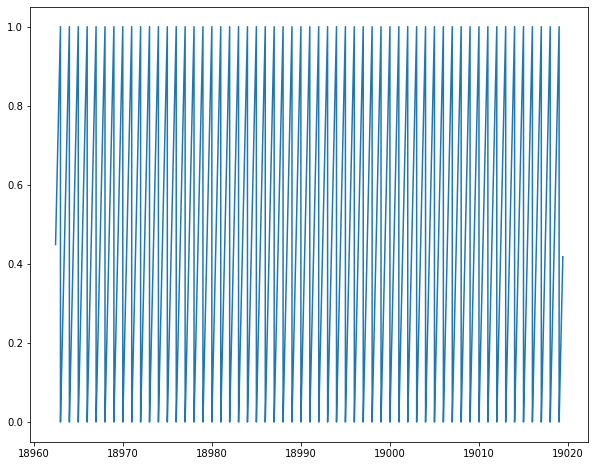

In [45]:
print('*** ', hourlies['time'][0:20])
fg = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.plot(hourlies['time'], hourlies['time']%1.>.)

In [47]:
17./24.

0.7083333333333334

In [ ]:
# let's just write explicit functions for periodic usage of cpus, jobs, other-stuff-too?
# We could use the existing tools to modulus-bin time-series, but I think it won't cost that much
# to just do it explicitly and (more) exactly. Trying to match up